# Transfer learning: training shallow classifiers on embedding models outputs

If you want to adapt BirdNET, Perch, HawkEars, or another foundation model to a new set of classes or a new domain, you'll be doing what machine learning experts call transfer learning. This tutorial demonstrates tranfer learning for PyToch models, but you can do the same with TensorFlow models such as BirdNET and Perch - examples are in a separate notebook `training_birdnet_and_perch.ipynb` since you might need to set your python environment up differently (by installing tensorflow and tensorflow-hub packages).

This notebook shows examples of how to train simple one-layer or multi-layer fully-connected neural networks (aka multi-layer perceptron networks, MLPs) on embedding (aka features) generated by a pre-trained deep learning model. This workflow is called transfer learning because the learned feature extraction of the embedding model is transfered to a new domain. Ghani et al. [1] demonstrated that gobal bird classification models can act as feature extractors that can be used to train shallow classifiers on novel tasks and domains, even when few training samples are available.

Training a shallow classifier on embeddings, rather than training or fine-tuning an entire deep learning model, has three advantages: (1) classifiers can be developed with just a handful of training examples; (2) models fit very quickly, enabling an iterative human-in-the-loop workflow for active learning; (3) any model that generates embeddings can be used as the feature extractor; in particular, compiled models without open-source weights (e.g. BirdNET [2]) can be used as the embedding model.

Users can develop flexible and customizable transfer-learning workflow by generating embeddings then using PyTorch or sklearn directly. This notebook demonstrates both (1) high-level functions and classes in OpenSoundscape that simplify the code needed to perform transfer learning; and (2) examples demonstrating the embedding and model fitting steps explicitly line-by-line.

[1] Ghani, B., T. Denton, S. Kahl, H. Klinck, T. Denton, S. Kahl, and H. Klinck. 2023. Global birdsong embeddings enable superior transfer learning for bioacoustic classification. Scientific Reports 13:22876.

[2] Kahl, Stefan, et al. "BirdNET: A deep learning solution for avian diversity monitoring." Ecological Informatics 61 (2021): 101236.


## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [1]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install git+https://github.com/kitzeslab/opensoundscape@develop ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0
  num_workers=0
else:
  num_workers=4

## Setup

### Import needed packages

In [42]:
#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Download and prepare training data


#### Download example files
Download a set of aquatic soundscape recordings with annotations of _Rana sierrae_ vocalizations

Option 1: run the cell below

- if you get a 403 error, DataDryad suspects you are a bot. Use Option 2. 

Option 2:

- Download and unzip the `rana_sierrae_2022.zip` folder containing audio and annotations from this [public Dryad dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.9s4mw6mn3#readme)
- Move the unzipped `rana_sierrae_2022` folder into the current folder

In [48]:
# Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# If you are not running this code in a notebook, input these commands into your terminal instead
!wget -O rana_sierrae_2022.zip https://datadryad.org/stash/downloads/file_stream/2722802;
!unzip rana_sierrae_2022;

--2024-10-01 12:19:48--  https://datadryad.org/stash/downloads/file_stream/2722802
Resolving datadryad.org (datadryad.org)... 52.12.241.68, 52.43.14.109, 52.10.58.171, ...
Connecting to datadryad.org (datadryad.org)|52.12.241.68|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-10-01 12:19:48 ERROR 403: Forbidden.

Archive:  rana_sierrae_2022.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  rana_sierrae_2022.ZIP
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.


#### Prepare audio data
See the train_cnn.ipynb tutorial for step-by-step walkthrough of this process, or just run the cells below to prepare a trainig set.

In [7]:
# Set the current directory to where the folder `rana_sierrae_2022` is located:
dataset_path = Path("./rana_sierrae_2022/")

# let's generate clip labels of 5s duration (to match HawkEars) using the raven annotations
# and some utility functions from opensoundscape
from opensoundscape.annotations import BoxedAnnotations
audio_and_raven_files = pd.read_csv(f"{dataset_path}/audio_and_raven_files.csv")
# update the paths to where we have the audio and raven files stored
audio_and_raven_files['audio'] = audio_and_raven_files['audio'].apply(lambda x: f"{dataset_path}/{x}")
audio_and_raven_files['raven'] = audio_and_raven_files['raven'].apply(lambda x: f"{dataset_path}/{x}")

annotations = BoxedAnnotations.from_raven_files(raven_files=audio_and_raven_files['raven'], audio_files=audio_and_raven_files['audio'],annotation_column='annotation')
# generate labels for 5s clips, including any labels that overlap by at least 0.2 seconds
labels = annotations.clip_labels(clip_duration=5,min_label_overlap=0.2)

/Users/SML161/opensoundscape/opensoundscape/annotations.py:300: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


#### Inspect labels

Count number of each annotation type: 

Note that the 'X' label is for when the annotator was uncertain about the identity of a call. Labels A-E denote distinct call types.

In [8]:
labels.sum()

A    512
E    128
D     62
B     24
C     74
X    118
dtype: int64

#### split into training and validation data
We'll just focus on class 'A', the call type with the most annotations. We'll randomly split the clips into training and validation data, acknowledging that this approach does not test the ability of the model to generalize. Since the samples in the training and validation sets could be adjascent 2-second audio clips, good performance could simply mean the model has memorized the training samples, and the validation set has very similar samples. 

In [9]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[['A']])

## Train shallow classifiers on embedding model outputs

We'll train our classifiers on a small annotated dataset with HawkEars, Perch, and BirdNET as feature extractors.

In [13]:
tag = "birdnet_train" # the branch of the model zoo with compatible models
hawk = torch.hub.load(
        f"kitzeslab/bioacoustics-model-zoo:{tag}", 'HawkEars', trust_repo=True, force_reload=True
    )

Downloading: "https://github.com/kitzeslab/bioacoustics-model-zoo/zipball/birdnet_train" to /Users/SML161/.cache/torch/hub/birdnet_train.zip


File hgnet1.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet1.ckpt...
File hgnet2.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet2.ckpt...
File hgnet3.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet3.ckpt...
File hgnet4.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet4.ckpt...
File hgnet5.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet5.ckpt...


/Users/SML161/opensoundscape/opensoundscape/ml/cnn.py:606: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/opensoundscape/opensoundscape/ml/cnn.py:63

Create a shallow classifier that we'll train with embeddings as inputs. The input size needs to match the size of the embeddings produced by our embedding model. HawkEars embeddings are vectors of length 2048. 

In [14]:
clf = MLPClassifier(input_size=2048,output_size=labels_train.shape[1],hidden_layer_sizes=())

We can run a single function that will embed the training and validation samples, then train the classifier.

This will take a minute or two, since all of the samples need to be embedded with HawkEars.

In [16]:
emb_train, label_train, emb_val, label_val = fit_classifier_on_embeddings(
    embedding_model=hawk,
    classifier_model=clf,
    train_df=labels_train, 
    validation_df=labels_val,
    steps=1000,
    embedding_batch_size=128,
    embedding_num_workers=0,
)

Embedding the training samples without augmentation


  0%|          | 0/8 [00:00<?, ?it/s]

Embedding the validation samples


  0%|          | 0/3 [00:00<?, ?it/s]

Fitting the classifier
Epoch 100/1000, Loss: 0.5504053831100464, Val Loss: 0.569046676158905
val AU ROC: 0.786
val MAP: 0.786


/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = to

Epoch 200/1000, Loss: 0.5045796632766724, Val Loss: 0.5255606770515442
val AU ROC: 0.801
val MAP: 0.801
Epoch 300/1000, Loss: 0.48286202549934387, Val Loss: 0.5047341585159302
val AU ROC: 0.808
val MAP: 0.808
Epoch 400/1000, Loss: 0.46923744678497314, Val Loss: 0.49295154213905334
val AU ROC: 0.815
val MAP: 0.815
Epoch 500/1000, Loss: 0.4590696096420288, Val Loss: 0.4857557415962219
val AU ROC: 0.819
val MAP: 0.819
Epoch 600/1000, Loss: 0.45071759819984436, Val Loss: 0.481211394071579
val AU ROC: 0.820
val MAP: 0.820
Epoch 700/1000, Loss: 0.4434584975242615, Val Loss: 0.4783158004283905
val AU ROC: 0.820
val MAP: 0.820
Epoch 800/1000, Loss: 0.43692171573638916, Val Loss: 0.47650381922721863
val AU ROC: 0.821
val MAP: 0.821
Epoch 900/1000, Loss: 0.43089839816093445, Val Loss: 0.47543829679489136
val AU ROC: 0.820
val MAP: 0.820
Epoch 1000/1000, Loss: 0.42526116967201233, Val Loss: 0.47490745782852173
val AU ROC: 0.820
val MAP: 0.820
Training complete


let's evaluate our shallow classifier on the test set:

In [17]:
# predict classes with the shallow classifier starting from the embeddings
preds = clf(emb_val.to(torch.device('cpu'))).detach().numpy()

# evaluate with threshold agnostic metrics: MAP and ROC AUC
print(f"average precision score: {average_precision_score(label_val,preds,average=None)}")
print(f"area under ROC: {roc_auc_score(label_val,preds,average=None)}")

average precision score: 0.8200562536402816
area under ROC: 0.8206738584306192


to visualize the performance, let's plot histograms of classifier logit scores for positive and negative samples

it shows that precision is good for scores above >0 (few negatives get high scores), but recall is only moderate (many positive samples get low scores)

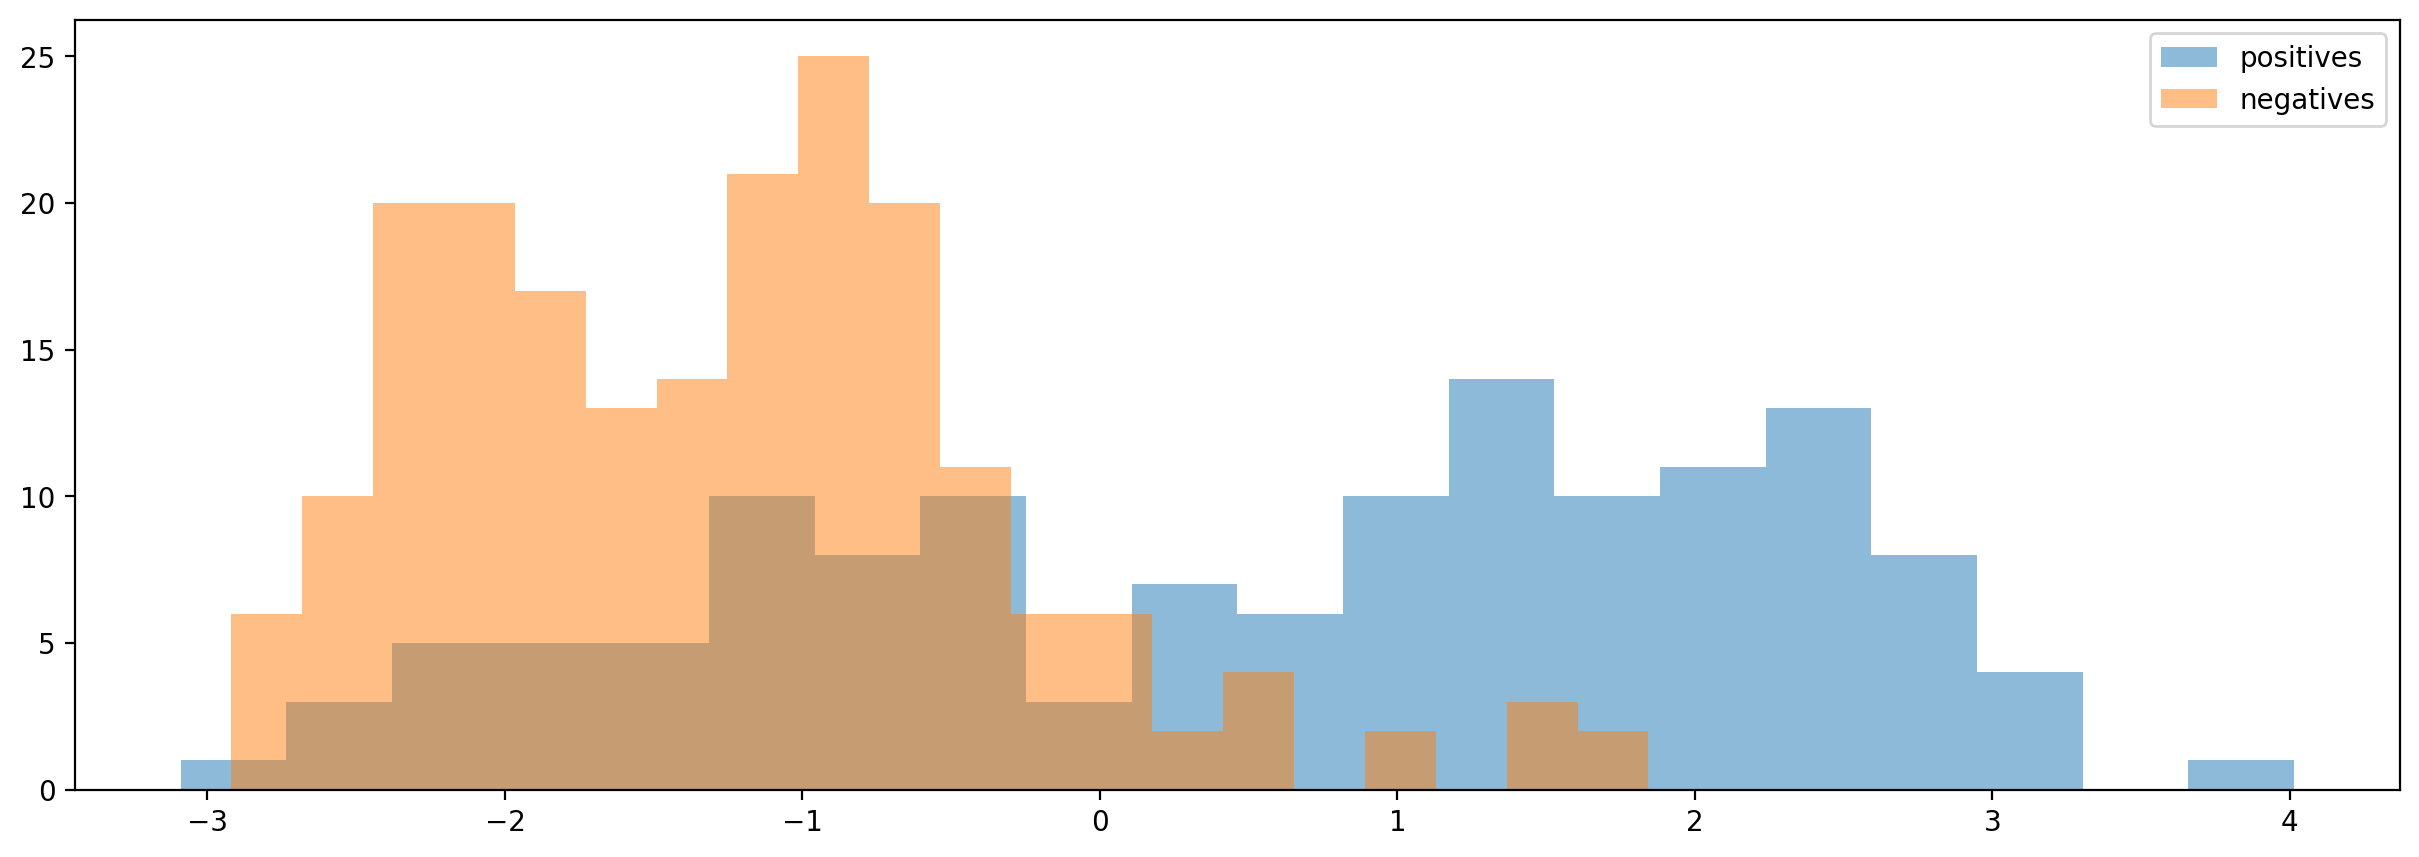

In [26]:
plt.hist(preds[label_val==1],bins=20,alpha=0.5,label='positives')
plt.hist(preds[label_val==0],bins=20,alpha=0.5,label='negatives')
plt.legend()

Alternatively, we can embed the training and validation sets first, then train as many different variants as we want.

(note that the `fit_classifier_on_embeddings` returns the embeddings on the training and validation set, so if you've already run that functino you don't need to re-generate the embeddings)

Generally, embedding may take a while for large datasets, but training the shallow classifier will be very fast because the network is small and there is no preprocessing or data loading. 

For example, here we compare fitting classifiers with one or two hidden layers on the same data:

In [76]:
# uncomment to generate training and validation set embeddings, if you don't have them from the previous cells
# emb_train = hawk.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
# emb_val = hawk.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

In [28]:
# define classifier with one hidden layer, and fit
classifier_model_1 = MLPClassifier(2048,1,hidden_layer_sizes=(100,))
classifier_model_1.fit(emb_train,labels_train.values,emb_val,labels_val.values,steps=1000)

# define classifier with two hidden layers, and fit
classifier_model_2 = MLPClassifier(2048,1,hidden_layer_sizes=(100,100))
classifier_model_2.fit(emb_train,labels_train.values,emb_val,labels_val.values,steps=1000)


/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.4328511655330658, Val Loss: 0.47238826751708984
val AU ROC: 0.822
val MAP: 0.822
Epoch 200/1000, Loss: 0.35831186175346375, Val Loss: 0.4938635230064392
val AU ROC: 0.811
val MAP: 0.811
Epoch 300/1000, Loss: 0.2807732820510864, Val Loss: 0.5692119002342224
val AU ROC: 0.780
val MAP: 0.780
Epoch 400/1000, Loss: 0.21449348330497742, Val Loss: 0.6902294754981995
val AU ROC: 0.745
val MAP: 0.745
Epoch 500/1000, Loss: 0.16480979323387146, Val Loss: 0.8208259344100952
val AU ROC: 0.723
val MAP: 0.723
Epoch 600/1000, Loss: 0.12880463898181915, Val Loss: 0.9493109583854675
val AU ROC: 0.712
val MAP: 0.712
Epoch 700/1000, Loss: 0.10222733020782471, Val Loss: 1.074968934059143
val AU ROC: 0.705
val MAP: 0.705
Epoch 800/1000, Loss: 0.08223725855350494, Val Loss: 1.1964682340621948
val AU ROC: 0.700
val MAP: 0.700
Epoch 900/1000, Loss: 0.06645628064870834, Val Loss: 1.3184123039245605
val AU ROC: 0.695
val MAP: 0.695
Epoch 1000/1000, Loss: 0.05397486314177513, Val Loss: 1.4

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.3394748568534851, Val Loss: 0.525502622127533
val AU ROC: 0.796
val MAP: 0.796
Epoch 200/1000, Loss: 0.17602656781673431, Val Loss: 0.8525370359420776
val AU ROC: 0.723
val MAP: 0.723
Epoch 300/1000, Loss: 0.09768013656139374, Val Loss: 1.2136679887771606
val AU ROC: 0.694
val MAP: 0.694
Epoch 400/1000, Loss: 0.055668119341135025, Val Loss: 1.579373836517334
val AU ROC: 0.682
val MAP: 0.682
Epoch 500/1000, Loss: 0.03132236748933792, Val Loss: 1.9363853931427002
val AU ROC: 0.675
val MAP: 0.675
Epoch 600/1000, Loss: 0.017640260979533195, Val Loss: 2.258981704711914
val AU ROC: 0.670
val MAP: 0.670
Epoch 700/1000, Loss: 0.01018973533064127, Val Loss: 2.5452704429626465
val AU ROC: 0.668
val MAP: 0.668
Epoch 800/1000, Loss: 0.006388748064637184, Val Loss: 2.785379409790039
val AU ROC: 0.663
val MAP: 0.663
Epoch 900/1000, Loss: 0.004310470074415207, Val Loss: 2.9844276905059814
val AU ROC: 0.660
val MAP: 0.660
Epoch 1000/1000, Loss: 0.0030799831729382277, Val Loss: 

In [29]:
# evaluate
preds = classifier_model_1(emb_val)
print(f"classifier_model_1 area under ROC: {roc_auc_score(labels_val.values,preds.detach().numpy(),average=None)}")

preds = classifier_model_2(emb_val)
print(f"classifier_model_2 area under ROC: {roc_auc_score(labels_val.values,preds.detach().numpy(),average=None)}")


classifier_model_1 area under ROC: 0.7250997487808482
classifier_model_2 area under ROC: 0.7066646963203782


# train on variants of the embeddings generated with audio-space augmentations

The `fit_classifier_on_embeddings` function supports generating variants of training samples with augmentation via the parameter `n_augmentation_variants`. The default 0 does not perform augentation. Specifying a positive integer tells the function to generate each sample n times using stochastic augmentation. The specific augmentations performed are defined by the embedding model's `.preprocessor`. 

We can also generate the augmented samples directly using `opensoundscape.ml.shallow_classifier.augmented_embed`, similarly to how we generated embeddings above then trained various models on them. Note that preprocessing and sample loading is repeated for each iteration of augmented data creation, so augmented_embed will take `n_augmentation_variants` times longer than embedding without augmentation. The benefit is that augmenting the audio samples before embedding tends to improve model performance more than simply augmenting the embeddings themselves (e.g. by adding random noise). 

For the sake of speed, we demonstrate augmented embedding here on only a subset of the training data

In [82]:
from opensoundscape.ml.shallow_classifier import augmented_embed
train_emb_aug, train_label_aug = augmented_embed(hawk,labels_train.sample(512), batch_size=128, num_workers=num_workers,n_augmentation_variants=4)

  0%|          | 0/4 [00:00<?, ?it/s]

we embed the validation set as normal, without any augmentation

In [83]:
# uncomment and run if you don't already have emb_val from previous steps
# emb_val = hawk.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

fitting the classifier on the augmented variants' embeddings looks the same as before:

In [84]:
classifier_model = MLPClassifier(2048,1,hidden_layer_sizes=())
quick_fit(classifier_model,train_emb_aug,train_label_aug,emb_val,labels_val.values,steps=1000)

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = to

Epoch 100/1000, Loss: 0.5731930136680603, Val Loss: 0.5386222004890442
val AU ROC: 0.686
val MAP: 0.804
Epoch 200/1000, Loss: 0.5672345757484436, Val Loss: 0.5133479237556458
val AU ROC: 0.722
val MAP: 0.849
Epoch 300/1000, Loss: 0.5619651079177856, Val Loss: 0.49430927634239197
val AU ROC: 0.726
val MAP: 0.856
Epoch 400/1000, Loss: 0.5574646592140198, Val Loss: 0.48154041171073914
val AU ROC: 0.728
val MAP: 0.859
Epoch 500/1000, Loss: 0.5536506175994873, Val Loss: 0.473262757062912
val AU ROC: 0.729
val MAP: 0.861
Epoch 600/1000, Loss: 0.5503987073898315, Val Loss: 0.46757546067237854
val AU ROC: 0.730
val MAP: 0.863
Epoch 700/1000, Loss: 0.5475777387619019, Val Loss: 0.4630894660949707
val AU ROC: 0.731
val MAP: 0.865
Epoch 800/1000, Loss: 0.5450759530067444, Val Loss: 0.45898887515068054
val AU ROC: 0.732
val MAP: 0.866
Epoch 900/1000, Loss: 0.5428107380867004, Val Loss: 0.4548884928226471
val AU ROC: 0.732
val MAP: 0.867
Epoch 1000/1000, Loss: 0.5407251715660095, Val Loss: 0.450669

evaluate:

In [86]:
preds = classifier_model(torch.tensor(emb_val).to(torch.device('cpu')))
roc_auc_score(labels_val.values,preds.detach().numpy(),average=None)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_48213/1177080571.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = classifier_model(torch.tensor(emb_val).to(torch.device('cpu')))


0.8678176493727874

## Fit SKLearn Classifiers on embeddings
scikit-learn provides various classification algorithms as alternatives to the MLPClassifier implemented in OpenSoundscape via PyTorch. It's straightforward to fit any sklearn model on embeddings: 

In [89]:
from sklearn.ensemble import RandomForestClassifier

# initialize a random forest class from sklearn
rf = RandomForestClassifier()

# fit the model on training set embeddings
rf.fit(emb_train,labels_train.values[:,0])

# evaluate on the validation set
preds = rf.predict(emb_val)
roc_auc_score(labels_val.values,preds,average=None)

0.804932975150205

here's another example with K nearest neighbors classification:

In [91]:
from sklearn.neighbors import KNeighborsClassifier

# initialize classifier
knc = KNeighborsClassifier()

# fit on training set embeddings
knc.fit(emb_train,labels_train.values[:,0])

# evaluate on validation set
preds = knc.predict(emb_val)
roc_auc_score(labels_val.values,preds,average=None)

0.8058895123845515

## Fit a classifier that is a layer in an exisisting OpenSoundscape model

If you have a fully connected layer at the end of an existing OpenSoundscape model, training that layer works similarly to training a separate MLPClassifier object. We can use the `quick_fit` function to train the layer on pre-generated embeddings (output of previous network layer) to avoid the slow-down associated with preprocessing samples for every training step. 

For example, let's load up a CNN trained in OpenSoundscape from the model zoo. This CNN was trained to detect the A and B call types of Rana Sierrae vocalizations. It has a resnet18 architecture that ends with a fully connected classifier layer. 

In [31]:
rana_sierrae_cnn = torch.hub.load(
    f"kitzeslab/bioacoustics-model-zoo:{tag}", 'rana_sierrae_cnn', trust_repo=True,
)
train_emb = rana_sierrae_cnn.embed(labels_train, return_dfs=False, batch_size=128, num_workers=num_workers)
val_emb = rana_sierrae_cnn.embed(labels_val, return_dfs=False, batch_size=128, num_workers=num_workers)

Using cache found in /Users/SML161/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_birdnet_train


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
# modify the last layer of the CNN to have a single output for the class 'A'
rana_sierrae_cnn.change_classes(['A']) # replace fc layer with 1-output layer

# fit the fc layer within the opso CNN by passing the layer to the `quick_fit` function
quick_fit(rana_sierrae_cnn.network.fc,train_emb,labels_train.values,val_emb,labels_val.values,steps=1000)

Epoch 100/1000, Loss: 0.4308735132217407, Val Loss: 0.4085293412208557
val AU ROC: 0.858
val MAP: 0.858
Epoch 200/1000, Loss: 0.39723220467567444, Val Loss: 0.4107294976711273
val AU ROC: 0.862
val MAP: 0.862
Epoch 300/1000, Loss: 0.3712672293186188, Val Loss: 0.41671693325042725
val AU ROC: 0.857
val MAP: 0.857
Epoch 400/1000, Loss: 0.350312739610672, Val Loss: 0.42410677671432495
val AU ROC: 0.854
val MAP: 0.854
Epoch 500/1000, Loss: 0.3329600393772125, Val Loss: 0.4327383041381836
val AU ROC: 0.851
val MAP: 0.851
Epoch 600/1000, Loss: 0.31827786564826965, Val Loss: 0.44232791662216187
val AU ROC: 0.846
val MAP: 0.846
Epoch 700/1000, Loss: 0.30561119318008423, Val Loss: 0.4525347352027893
val AU ROC: 0.841
val MAP: 0.841
Epoch 800/1000, Loss: 0.294492244720459, Val Loss: 0.4631038308143616
val AU ROC: 0.839
val MAP: 0.839
Epoch 900/1000, Loss: 0.28458428382873535, Val Loss: 0.4738853871822357
val AU ROC: 0.835
val MAP: 0.835
Epoch 1000/1000, Loss: 0.2756422460079193, Val Loss: 0.4848

In [35]:
# evaluate:

# can use regular prediction since we modified the in-network classifier
# but this will be slower than just running the fc layer on the embeddings, since it requires
# preprocessing and running the entire CNN architecture forward pass
preds = rana_sierrae_cnn.predict(labels_val, batch_size=128) 
roc_auc_score(labels_val.values,preds,average=None)

0.8525934683020541

We could equivalently get the prediciton by passing the embeddings through the trained fc layer. The outputs should be numerically similar to prediction starting from the audio clips:


In [41]:
preds2 = rana_sierrae_cnn.network.fc(torch.tensor(val_emb).to(torch.device('mps'))).detach().cpu().numpy()
np.max(np.abs((preds.values - preds2)))

0.0

We could also replace the cnn's `.fc` layer with an MLPClassifier object of course, if we want the classifier to be more than one fully-connected layer. 